<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/GCW_playcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing manipulations

# Install packages

In [26]:
# Comment after installation so that the whole notebook can be run in one go
install.packages('gbm')
install.packages('xgboost')
install.packages('pROC')
install.packages('reshape2')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Load Libraries

In [27]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(gbm)
library(reshape2)
library(pROC)

# Create Functions

Actual vs Expected Plot

The A vs E plot function here accepts the dimension variable to review along with the actual and expected response information. The graph will show the ratio of these results to weight. Input actual, expected and weight accordingly. Also, no binning takes place within the code. Please create a binned version for review before passing the information into the function where desired.

In [28]:
## avse.plot.classification includes an off balance for when the model overall predicts low or high
## this is essentially the resid.plot function used later in the regression case study
## here, actual and pred align and both are "numerators"
## in resid.plot, we pass actual loss and pred pure prem, so converting pred pure prem
## is necessary. But, I digress.
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  a3 = paste0("data$",weight)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)) * eval(parse(text = a3)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}


Compute Model Metrics

The following function computes common classification measures for evaluating model results.

In [29]:
# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
# metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    # compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    # compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

# Build Our First GBM (today)

Simulate Some Data

First, we will create a dataset to model on. For our purposes, we'll borrow qualitatively our belief about risk differences by age.


*   Set x.Age to be between 16 and 90
*   Set probability of event to be some form of cosine function
*   Use the probabilities to generate binary outcomes



In [48]:
set.seed(31301)
N <- 200000
x.Age <- sample(16:90, N, replace = TRUE)
exposures <- rep(1, N)
y.truth <- (1+0.25*cos((x.Age-15)*pi/45))*.2
y.out <- rbinom(N, 1, prob=y.truth)

In [49]:
df <- data.frame(x.Age, exposures, y.truth, y.out)

In [50]:
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.5,0.5))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [51]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]


With the data in place, let's take just a little time to visualize our data.

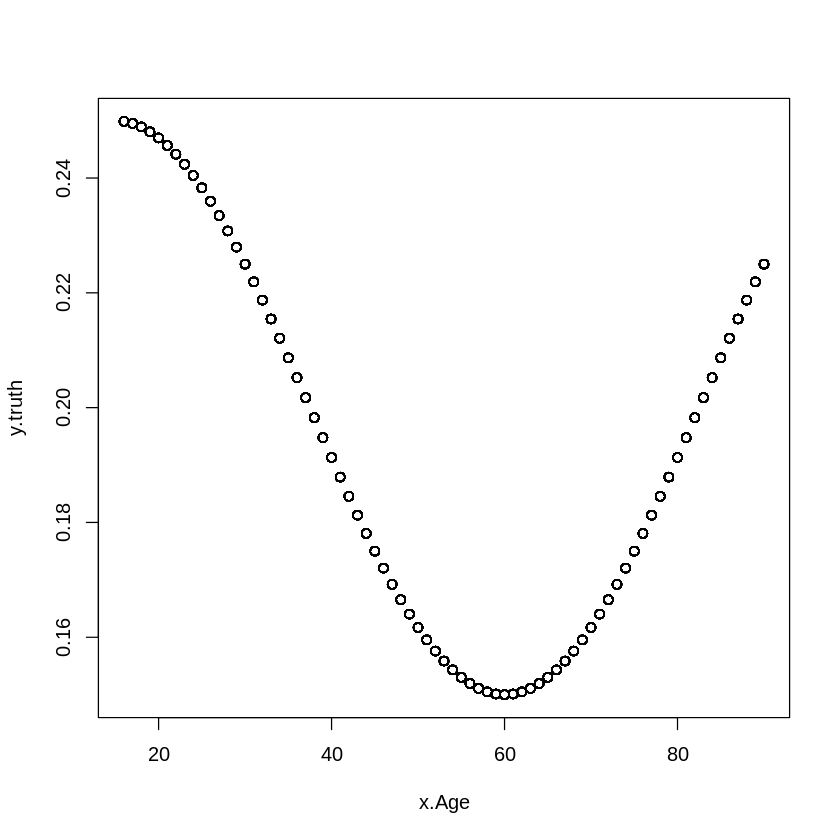

In [52]:
with(df.train, plot(x.Age, y.truth))

In [53]:
df2 <- df.train %>% 
  group_by(x.Age) %>% 
  summarise(reccnt = n(), 
            sum.true = sum(y.truth),
            sum.actual = sum(y.out)) %>%
  mutate(f.true = sum.true / reccnt,
         f.actual = sum.actual / reccnt)
df2                
              

x.Age,reccnt,sum.true,sum.actual,f.true,f.actual
<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
16,1346,336.3361,329,0.2498782,0.2444279
17,1239,309.1471,303,0.2495134,0.2445521
18,1314,327.0643,317,0.2489074,0.2412481
19,1273,315.7843,320,0.2480631,0.2513747
20,1286,317.6222,350,0.2469846,0.2721617
21,1326,325.7681,335,0.2456773,0.2526395
22,1327,323.9836,320,0.2441474,0.2411454
23,1320,319.9712,314,0.2424024,0.2378788
24,1345,323.4064,345,0.2404508,0.2565056


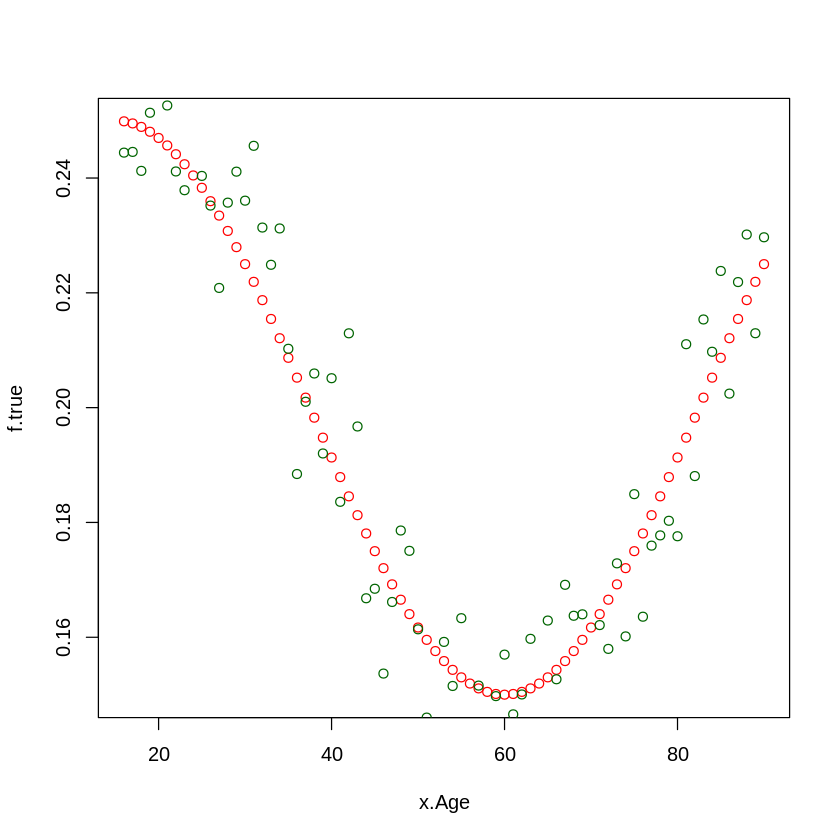

In [54]:
with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))

Let's take a moment and get familiar with the actual versus expected plotting function.

In the function below, by setting actual and predicted both to y.out, you get the univariate review of the actual results. Here, because we have the original probabilities, we can further set actual to y.truth and predicted to y.out, and get a visual comparison of the simulated results against the underlying truth.

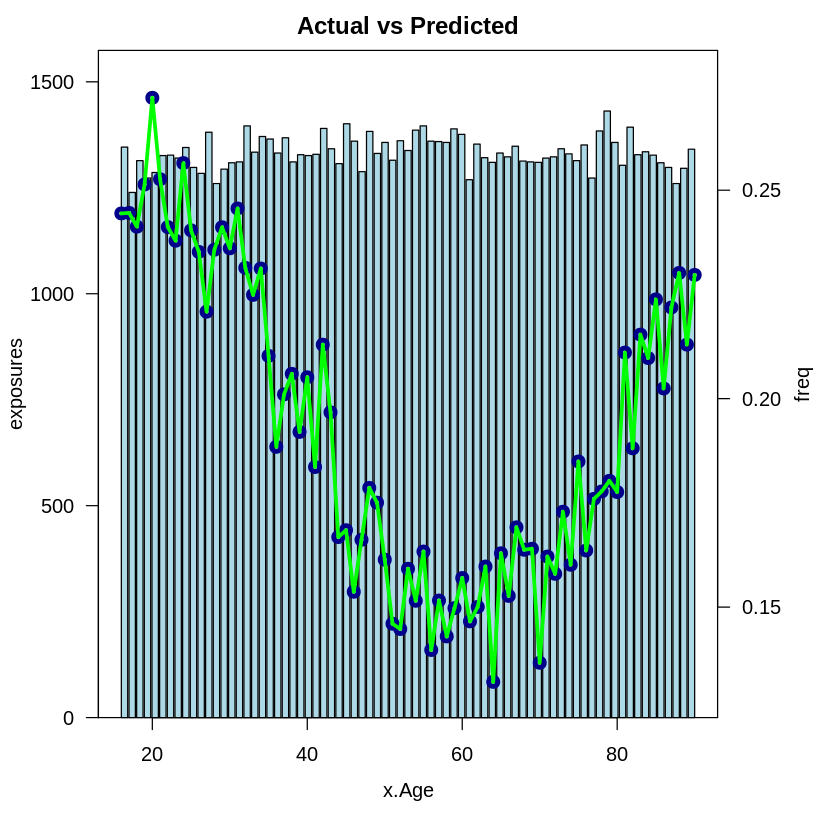

In [136]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.out",weight="exposures",lt_text="exposures",rt_text="freq")

Now, we're ready to start modeling. First, we'll work through some logistic regressions, along with polynomic forms.

In [138]:
m.glm <- glm(y.train ~ x.Age, data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm <- predict(m.glm, newdata=x.train, type="response")
df.test$y.pred.glm <- predict(m.glm, newdata=x.test, type="response")
summary(m.glm)


Call:
glm(formula = y.train ~ x.Age, family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7134  -0.6735  -0.6384  -0.6033   1.9058  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.1520303  0.0208566  -55.24   <2e-16 ***
x.Age       -0.0054046  0.0003736  -14.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97696  on 99972  degrees of freedom
AIC: 97700

Number of Fisher Scoring iterations: 4


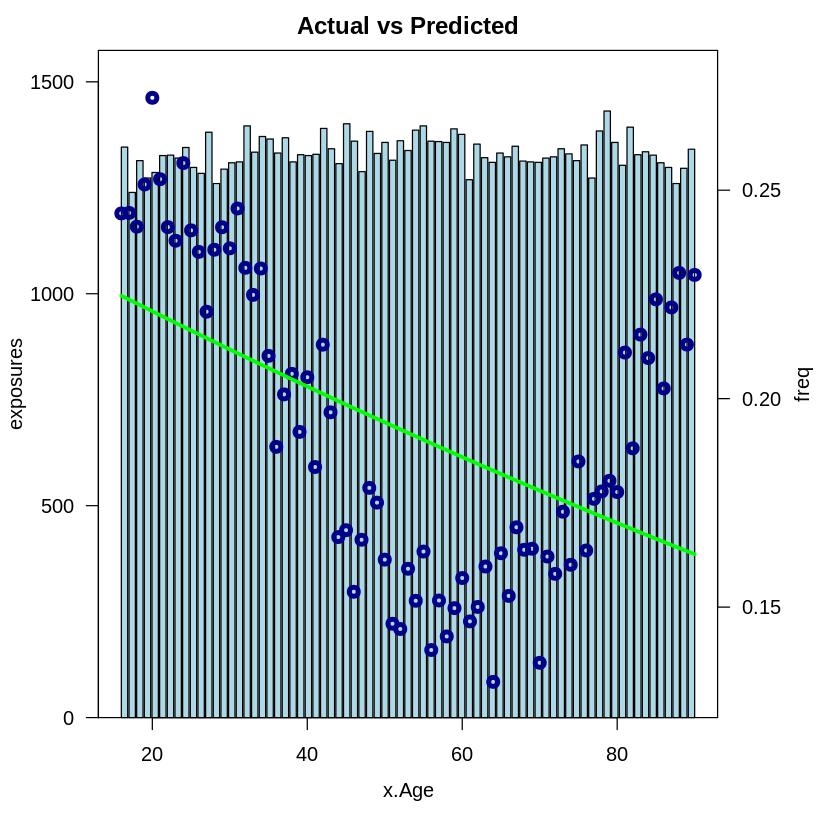

In [79]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

In [140]:
m.glm2 <- glm(y.train ~ poly(x.Age,2), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm2 <- predict(m.glm2, newdata=x.train, type="response")
df.test$y.pred.glm2 <- predict(m.glm2, newdata=x.test, type="response")
summary(m.glm2)

m.glm3 <- glm(y.train ~ poly(x.Age,3), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm3 <- predict(m.glm3, newdata=x.train, type="response")
df.test$y.pred.glm3 <- predict(m.glm3, newdata=x.test, type="response")
summary(m.glm3)


Call:
glm(formula = y.train ~ poly(x.Age, 2), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8281  -0.6658  -0.6140  -0.5934   1.9112  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.447005   0.008107 -178.50   <2e-16 ***
poly(x.Age, 2)1 -33.798828   2.442156  -13.84   <2e-16 ***
poly(x.Age, 2)2  53.669550   2.479010   21.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97234  on 99971  degrees of freedom
AIC: 97240

Number of Fisher Scoring iterations: 4



Call:
glm(formula = y.train ~ poly(x.Age, 3), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7752  -0.6843  -0.6106  -0.5763   1.9402  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.449131   0.008124 -178.381   <2e-16 ***
poly(x.Age, 3)1 -35.630016   2.448474  -14.552   <2e-16 ***
poly(x.Age, 3)2  54.607142   2.477759   22.039   <2e-16 ***
poly(x.Age, 3)3  21.566963   2.481274    8.692   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97158  on 99970  degrees of freedom
AIC: 97166

Number of Fisher Scoring iterations: 4


In [141]:
m.glm9 <- glm(y.train ~ poly(x.Age,9), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm9 <- predict(m.glm9, newdata=x.train, type="response")
df.test$y.pred.glm9 <- predict(m.glm9, newdata=x.test, type="response")
summary(m.glm9)


Call:
glm(formula = y.train ~ poly(x.Age, 9), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7630  -0.6994  -0.6053  -0.5718   1.9471  

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.44993    0.00813 -178.333  < 2e-16 ***
poly(x.Age, 9)1 -35.19172    2.44530  -14.392  < 2e-16 ***
poly(x.Age, 9)2  55.73235    2.51290   22.178  < 2e-16 ***
poly(x.Age, 9)3  21.18474    2.50257    8.465  < 2e-16 ***
poly(x.Age, 9)4 -12.84941    2.51180   -5.116 3.13e-07 ***
poly(x.Age, 9)5  -1.80144    2.50773   -0.718    0.473    
poly(x.Age, 9)6   0.84000    2.50835    0.335    0.738    
poly(x.Age, 9)7  -2.03703    2.50660   -0.813    0.416    
poly(x.Age, 9)8  -3.56014    2.49934   -1.424    0.154    
poly(x.Age, 9)9   1.60669    2.49710    0.643    0.520    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to 

In [142]:
m.glm4 <- glm(y.train ~ poly(x.Age,4), data=x.train, family=binomial(link='logit'))
df.train$y.pred.glm4 <- predict(m.glm4, newdata=x.train, type="response")
df.test$y.pred.glm4 <- predict(m.glm4, newdata=x.test, type="response")
summary(m.glm4)


Call:
glm(formula = y.train ~ poly(x.Age, 4), family = binomial(link = "logit"), 
    data = x.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7602  -0.6925  -0.6087  -0.5708   1.9492  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -1.449808   0.008129 -178.348  < 2e-16 ***
poly(x.Age, 4)1 -35.157658   2.444799  -14.381  < 2e-16 ***
poly(x.Age, 4)2  55.647256   2.509606   22.174  < 2e-16 ***
poly(x.Age, 4)3  21.123439   2.494221    8.469  < 2e-16 ***
poly(x.Age, 4)4 -12.711745   2.494108   -5.097 3.46e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97906  on 99973  degrees of freedom
Residual deviance: 97132  on 99969  degrees of freedom
AIC: 97142

Number of Fisher Scoring iterations: 4


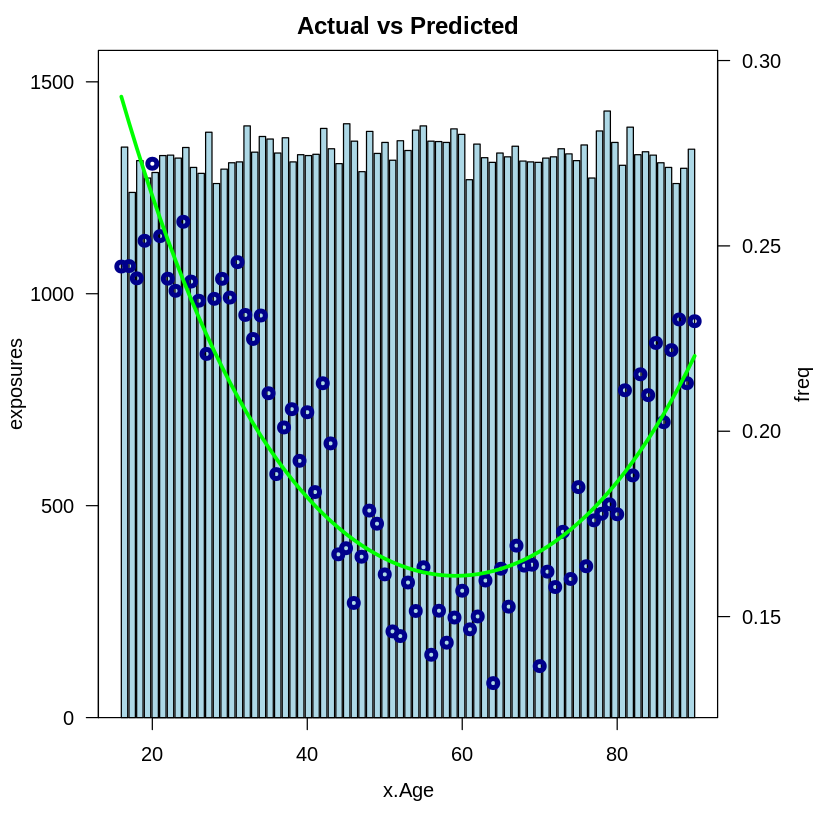

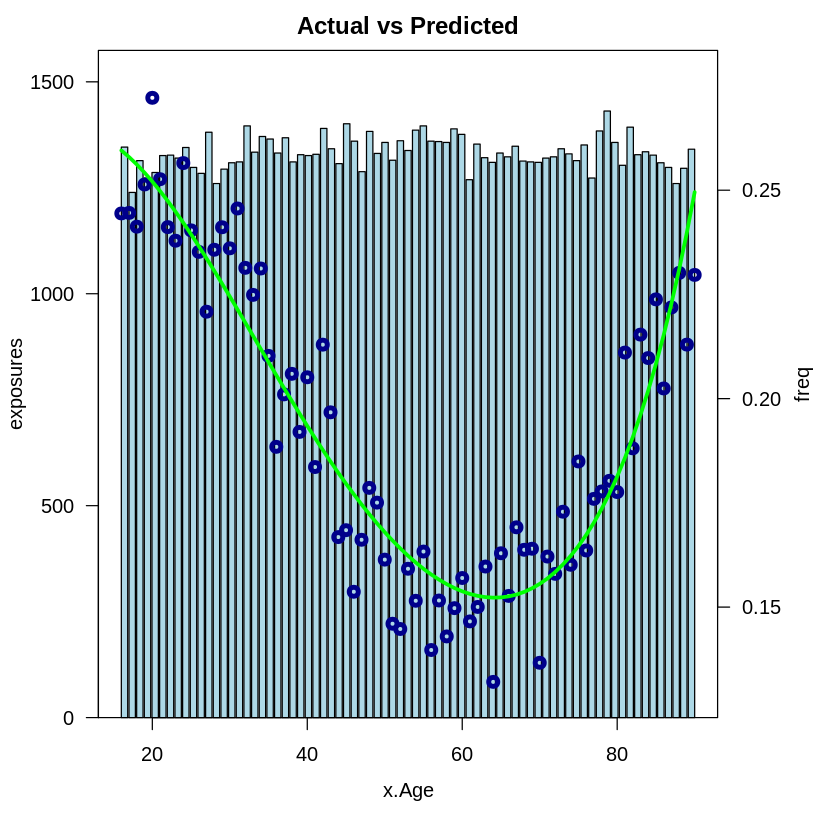

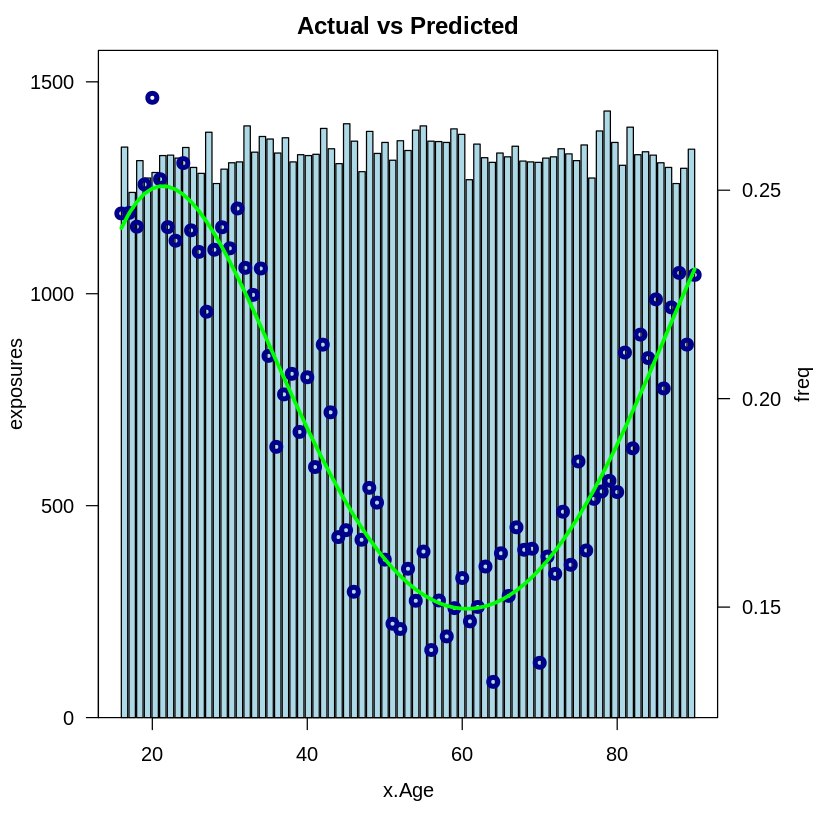

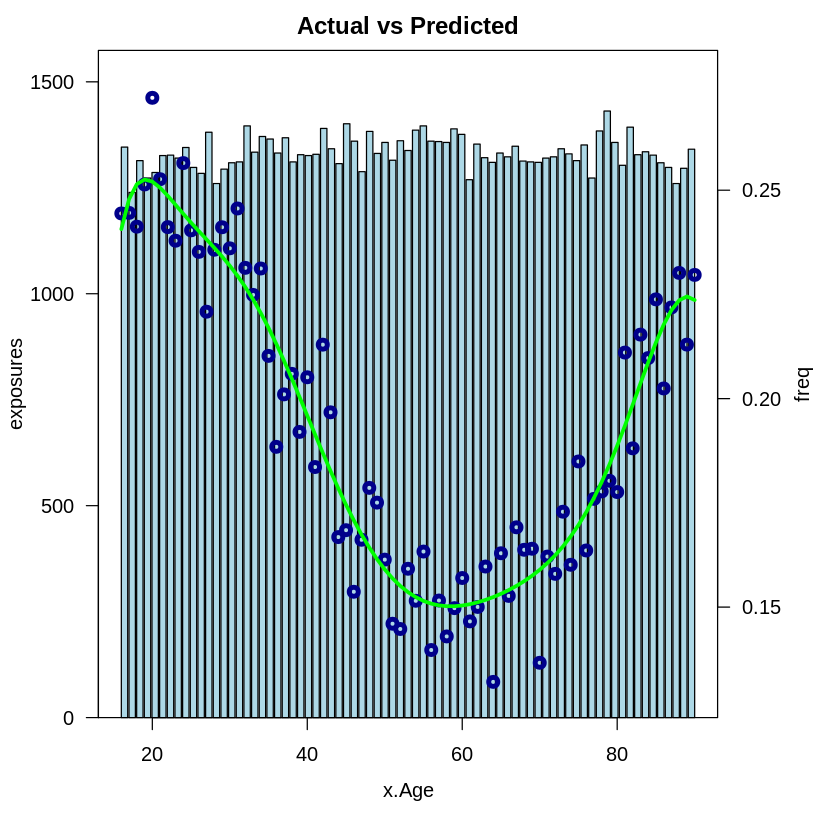

In [144]:
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm2",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm3",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm4",weight="exposures",lt_text="exposures",rt_text="freq")
avse.plot.classification(var="x.Age",data=df.train,actual="y.out",pred="y.pred.glm9",weight="exposures",lt_text="exposures",rt_text="freq")

With only one dimension for the model, it's easy to predict to each level directly. We already have a summarized file in df2. We'll use that to gather the GLM predictions and display them cleanly.

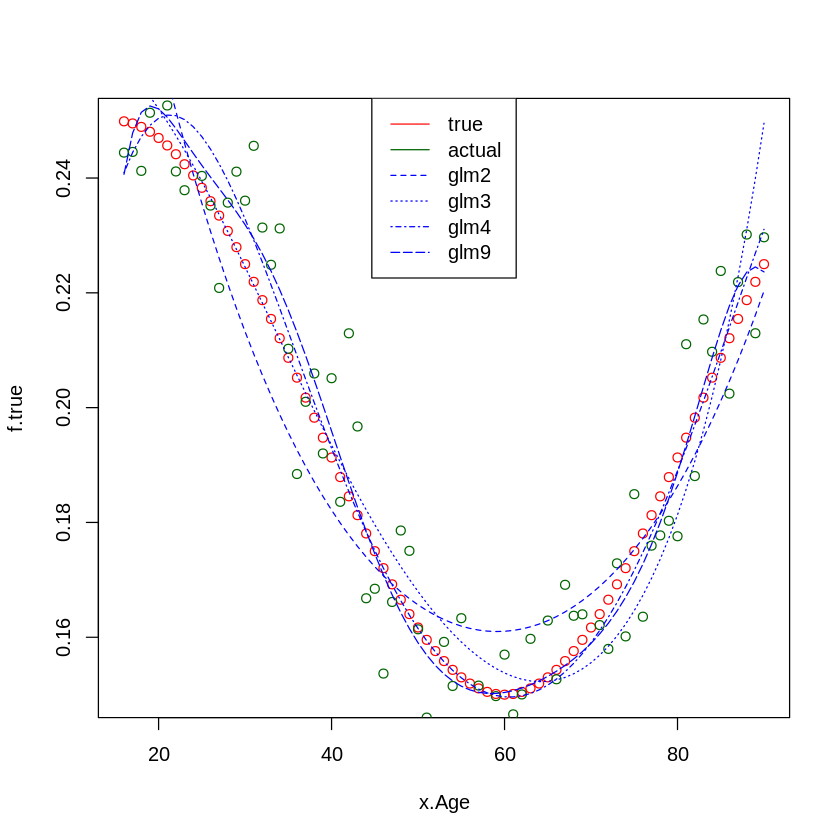

In [145]:
df2$f.pred.glm <- predict(m.glm, newdata=df2, type="response")
df2$f.pred.glm2 <- predict(m.glm2, newdata=df2, type="response")
df2$f.pred.glm3 <- predict(m.glm3, newdata=df2, type="response")
df2$f.pred.glm4 <- predict(m.glm4, newdata=df2, type="response")
df2$f.pred.glm9 <- predict(m.glm9, newdata=df2, type="response")

with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))
with(df2, lines(x.Age, f.pred.glm2, lty = 2, col="blue"))
with(df2, lines(x.Age, f.pred.glm3, lty = 3, col="blue"))
with(df2, lines(x.Age, f.pred.glm4, lty = 4, col="blue"))
with(df2, lines(x.Age, f.pred.glm9, lty = 5, col="blue"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm4", "glm9"),
       lty=c(1,1,2:5),
       col=c("red", "darkgreen", "blue", "blue", "blue", "blue"))

Now, let's turn our attention to the GBM. Without knowing much else about GBM, let's use as many defaults as we can, and just send the data through the function. Well, except I allowed myself the choice of distribution.

In [146]:
m.gbm = gbm(y.train ~ x.Age,
            data = x.train,
            distribution = "bernoulli")
df.train$y.pred.gbm <- predict(m.gbm, newdata=df.train, type="response")
df.test$y.pred.gbm <- predict(m.gbm, newdata=df.test, type="response")
df2$f.pred.gbm <- predict(m.gbm, newdata=df2, type="response")

Using 100 trees...


Using 100 trees...


Using 100 trees...




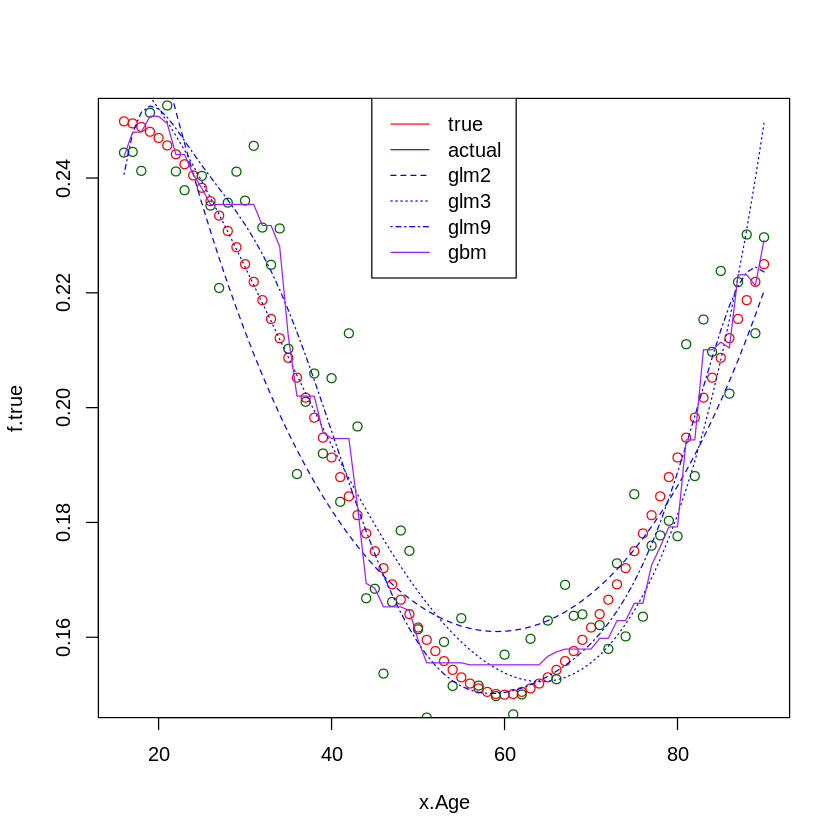

In [147]:
with(df2, plot(x.Age, f.true, col="red"))
with(df2, points(x.Age, f.actual, col="darkgreen"))
with(df2, lines(x.Age, f.pred.glm2, lty = 2, col="blue"))
with(df2, lines(x.Age, f.pred.glm3, lty = 3, col="blue"))
with(df2, lines(x.Age, f.pred.glm9, lty = 4, col="blue"))
with(df2, lines(x.Age, f.pred.gbm, lty = 1, col="purple"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm9", "gbm"),
       lty=c(1,1,2:4,1),
       col=c("red", "darkgreen", "blue", "blue", "blue", "purple"))

Congrats. There's your first GBM (of today).

We won't call it done here just yet. Let's get comfortable looking reviewing fit. The first hyperparameter we'll play with is the number of trees. In the gbm function this is the n.trees option. Default is 100.

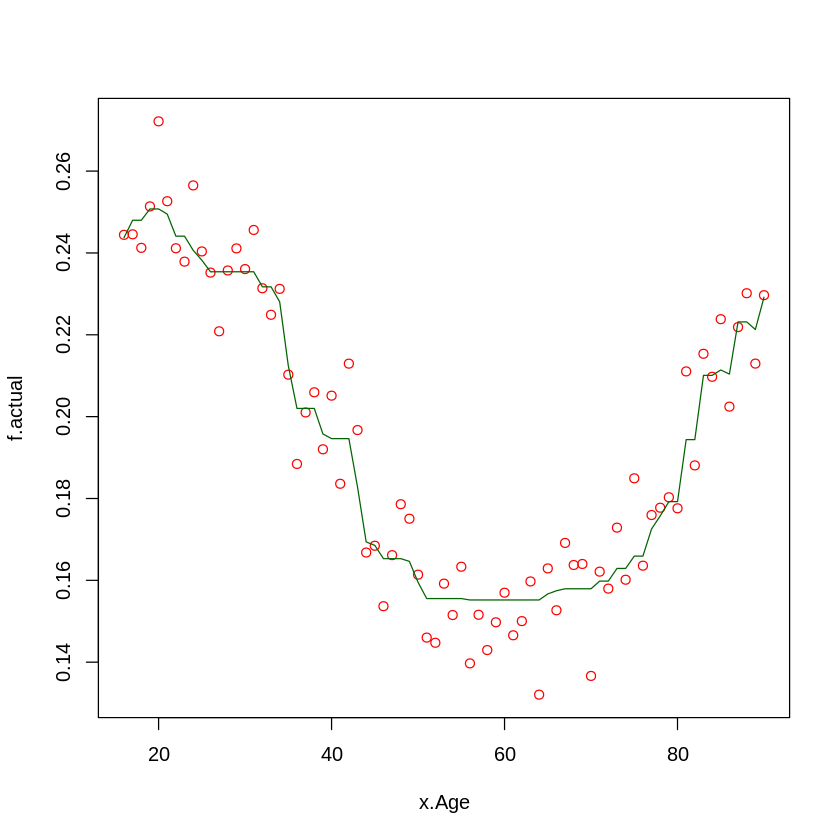

In [156]:
df2$f.pred.gbm.iter <- predict(m.gbm, newdata=df2, type="response", n.trees=100)
with(df2, plot(x.Age, f.actual, col="red"))
with(df2, lines(x.Age, f.pred.gbm.iter, col="darkgreen"))

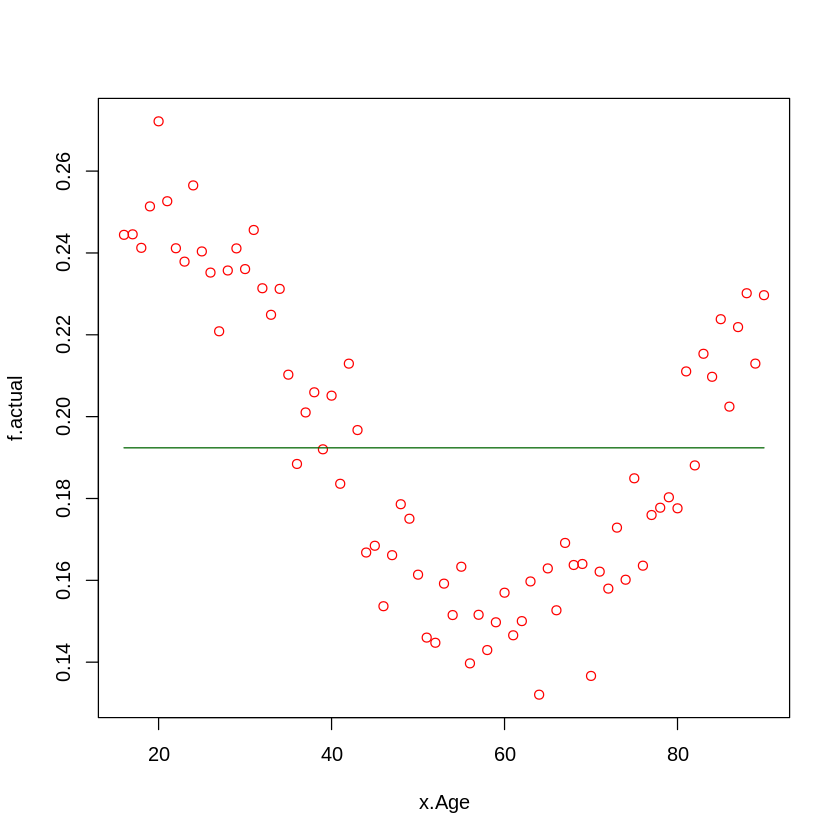

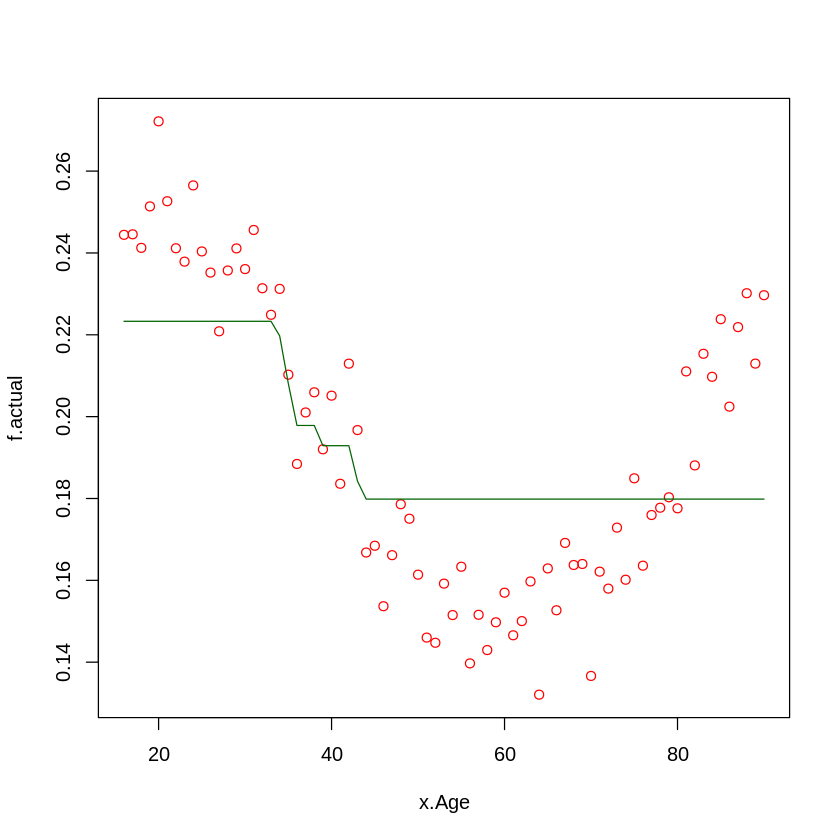

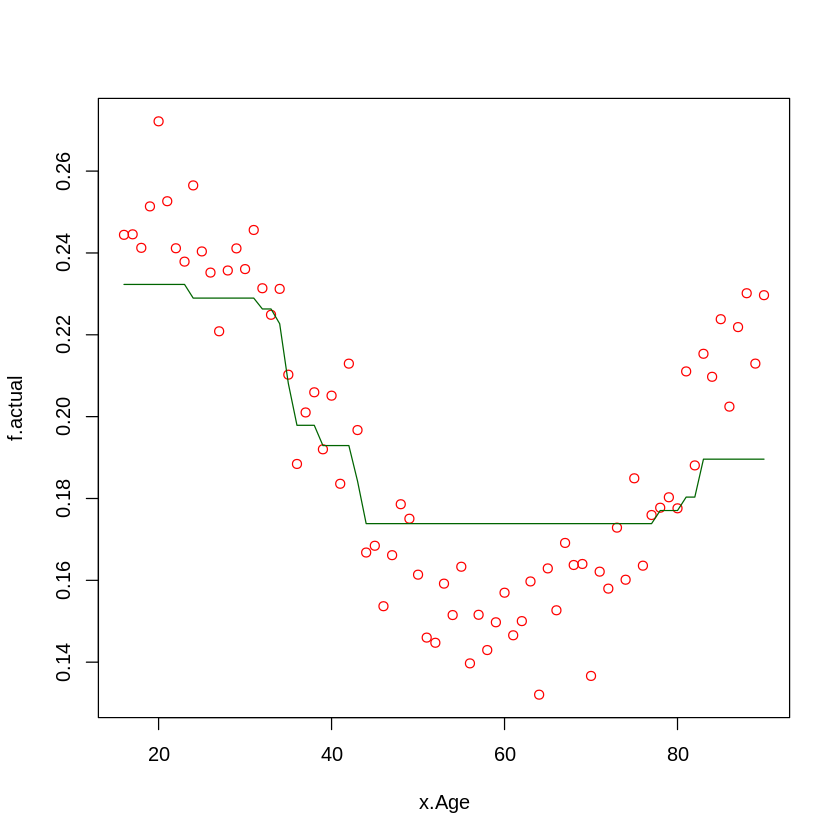

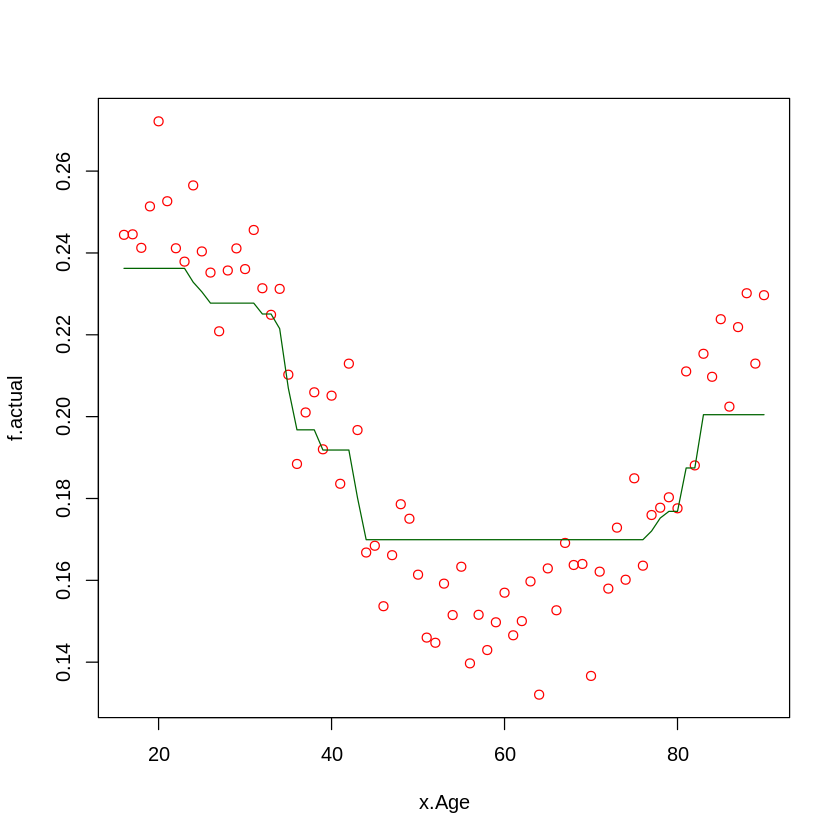

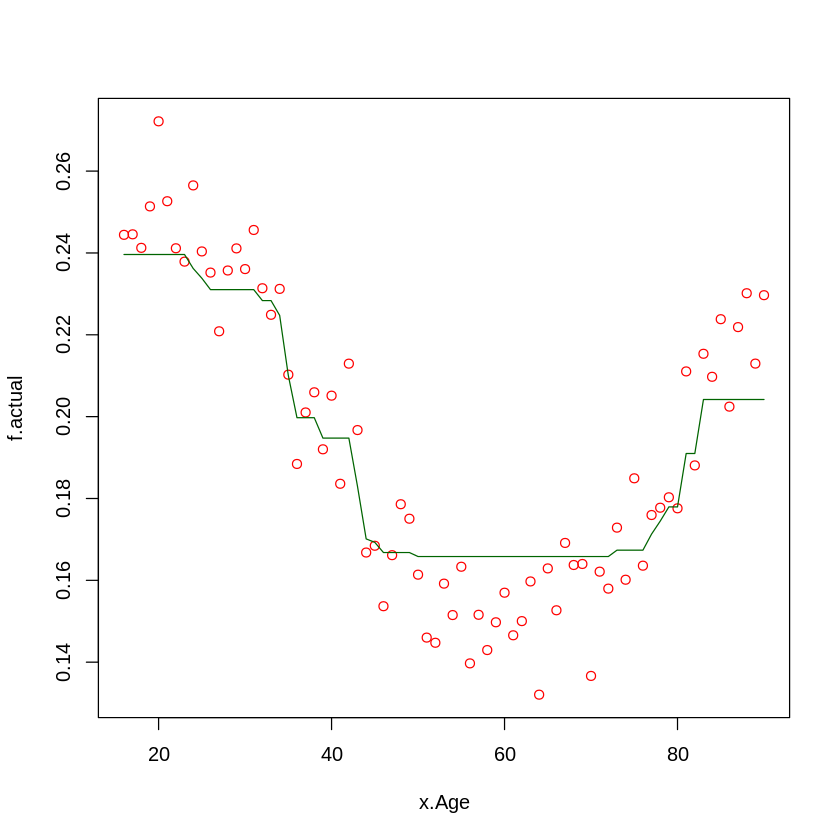

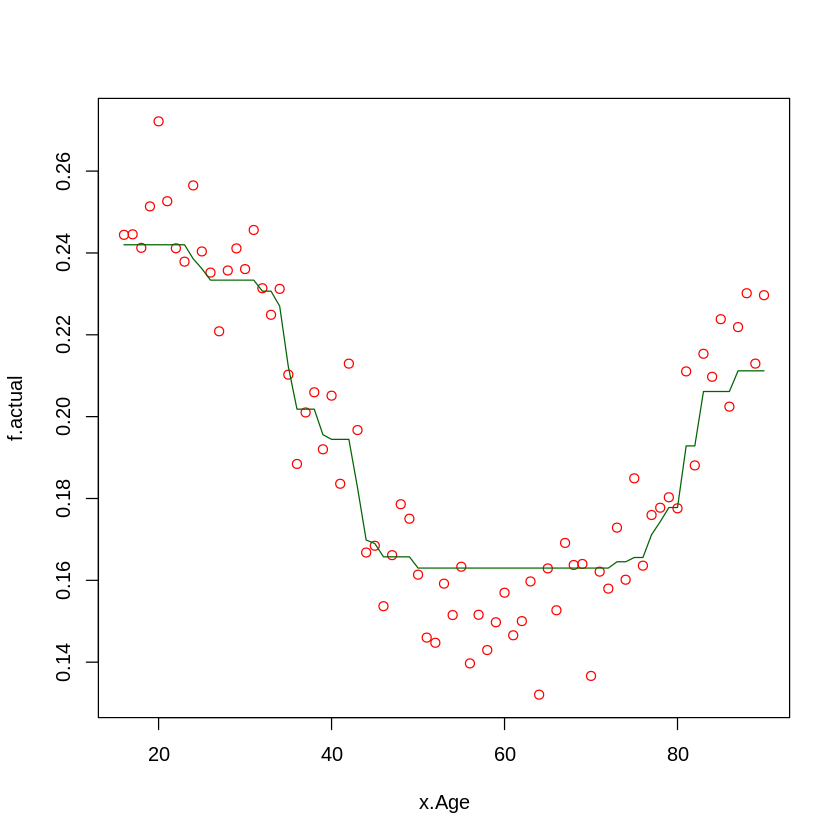

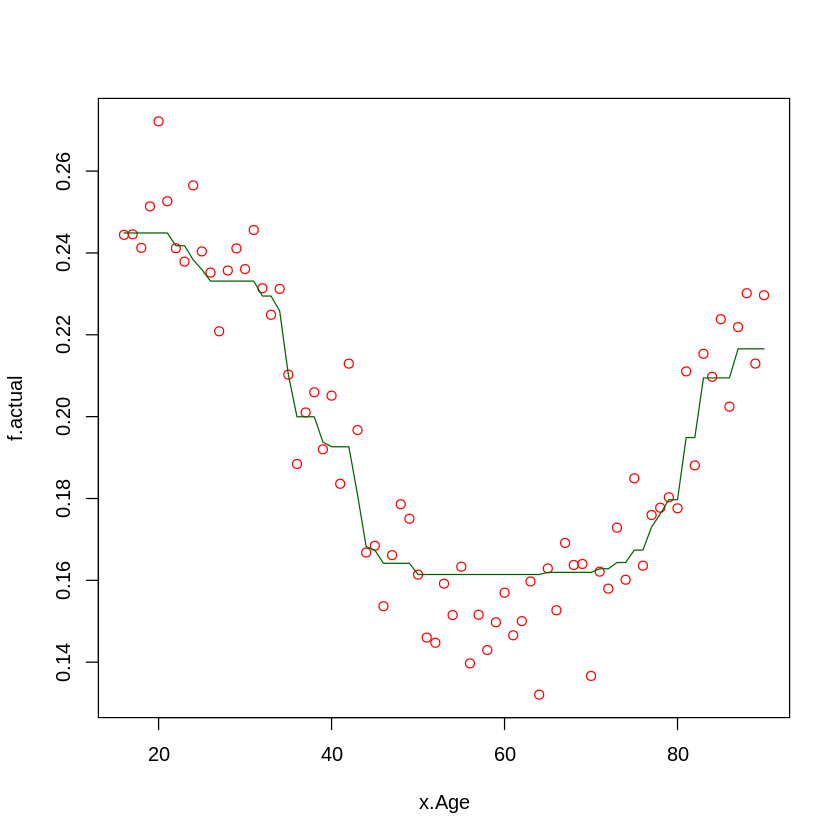

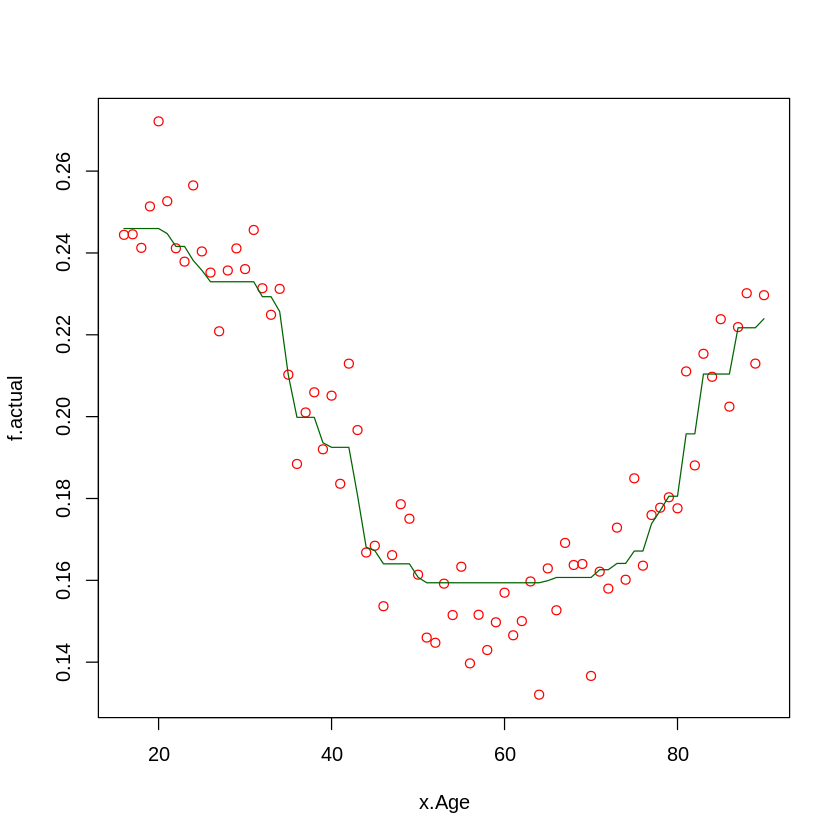

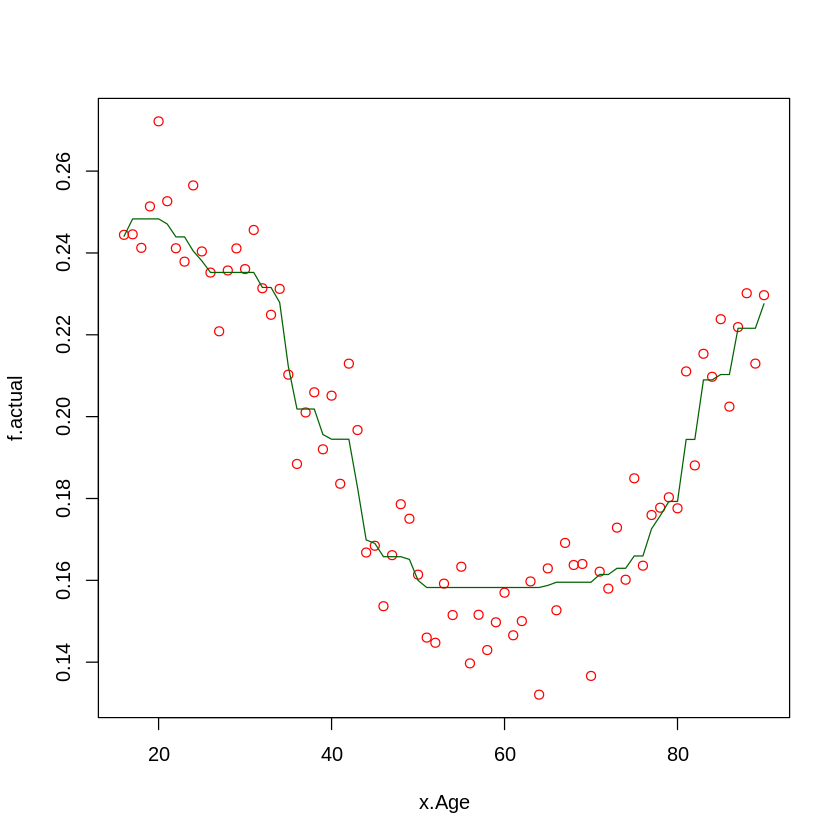

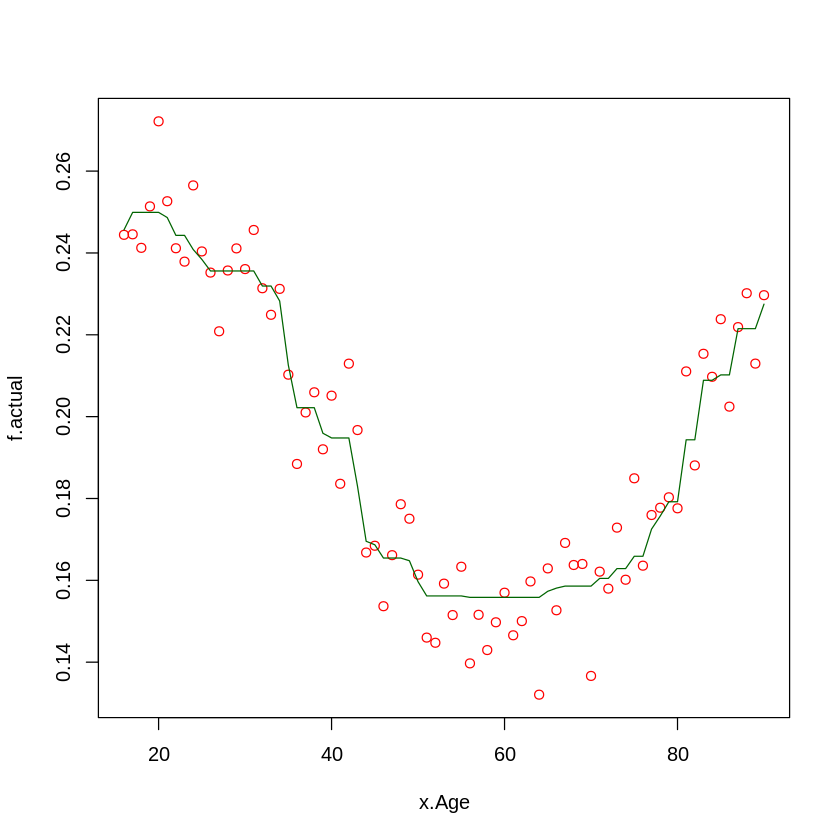

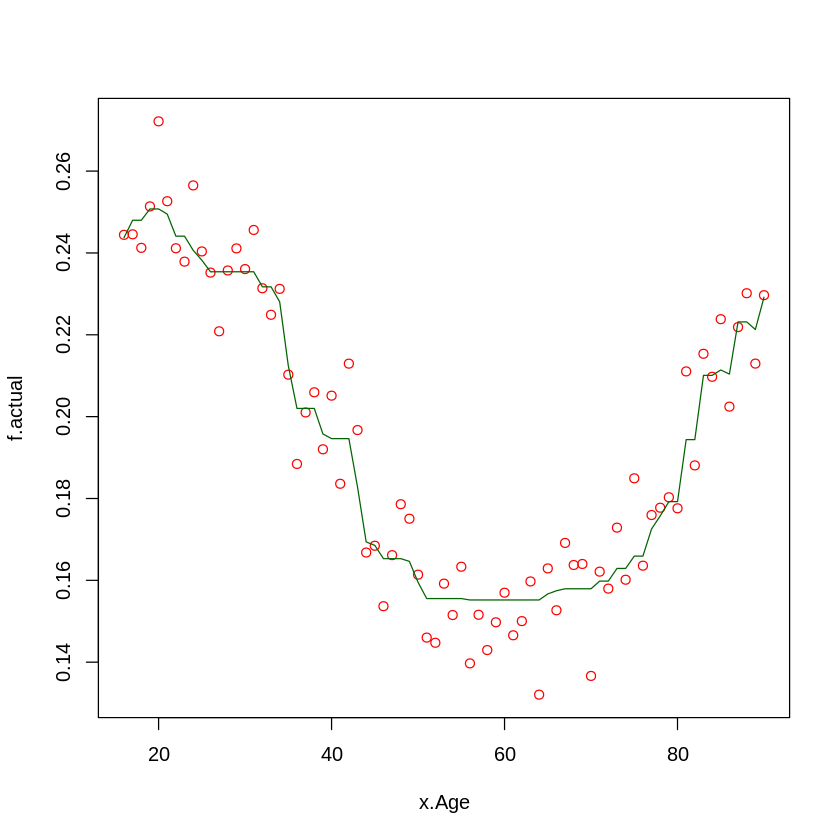

In [157]:
with(df2, plot(x.Age, f.actual, col="red"))
for (i in seq(0, 100, 10)) {
  df2$f.pred.gbm.iter <- predict(m.gbm, newdata=df2, type="response", n.trees=i)
  with(df2, plot(x.Age, f.actual, col="red"))
  with(df2, lines(x.Age, f.pred.gbm.iter, col="darkgreen"))
}

# Evaluate Results

Lift Charts are a particular case of the Actual vs Expected plots. Instead of a variable, we line up the information based on the predicted responses. We then bin and check Actual vs Expected in the bins.

As we are evaluating results, let's turn our attention to the test data going forward.

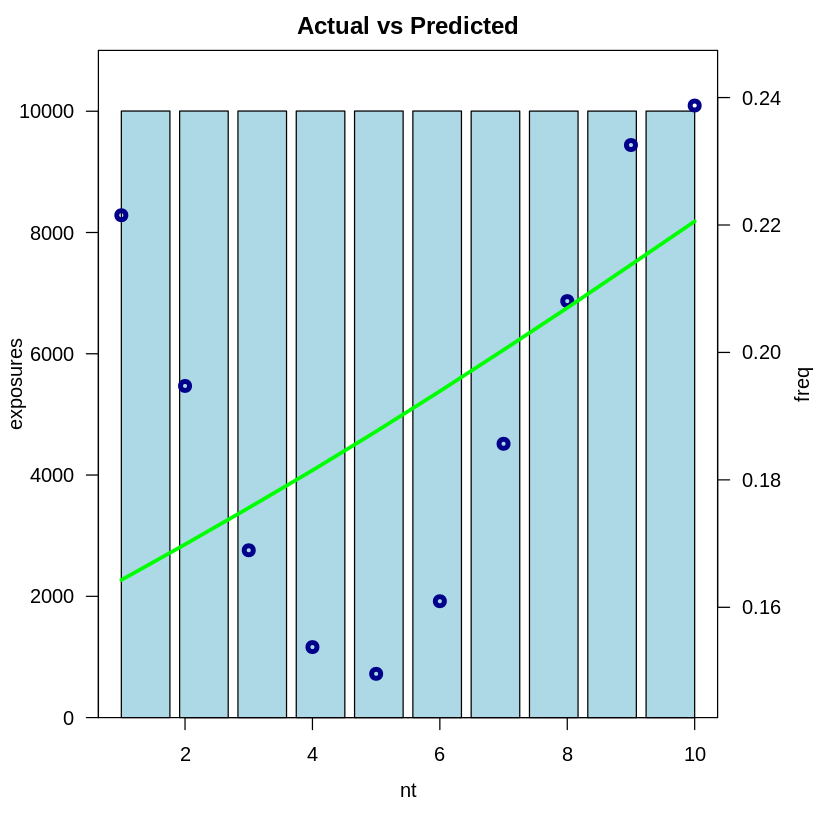

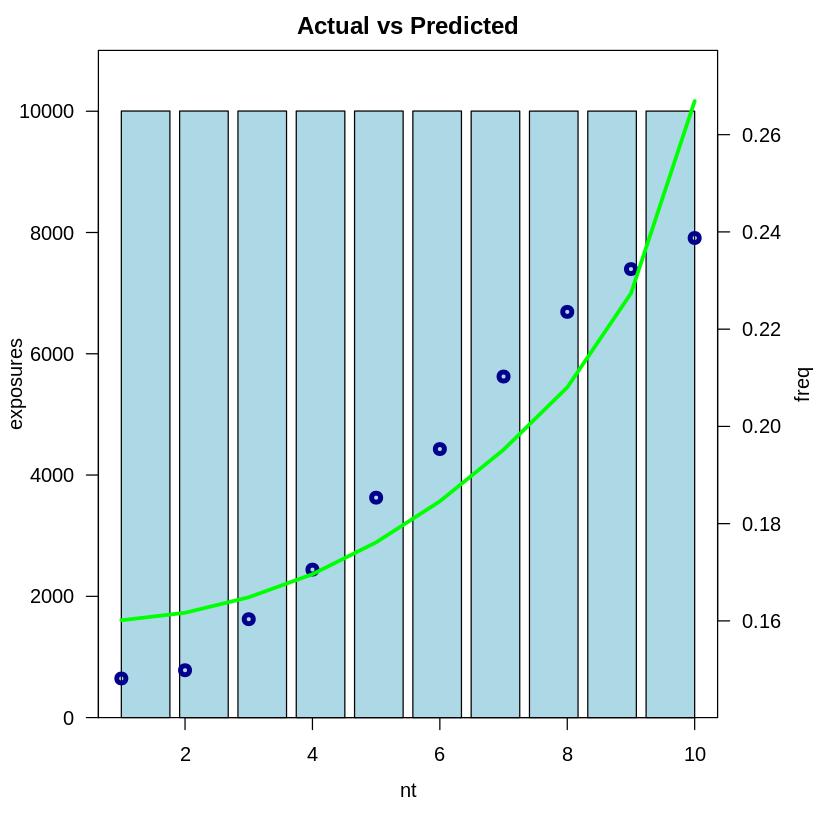

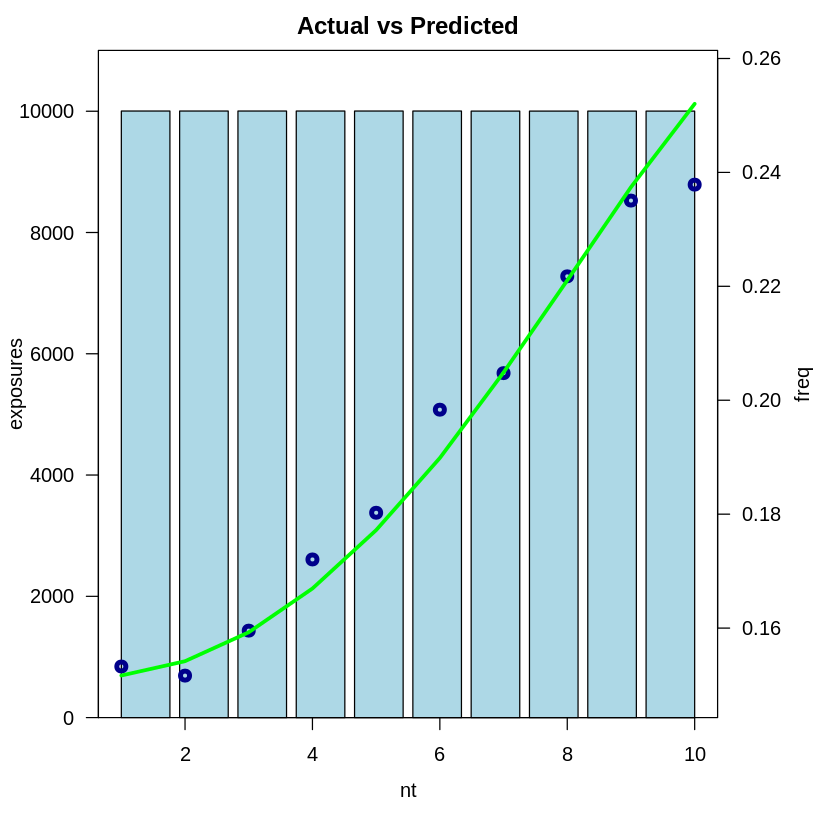

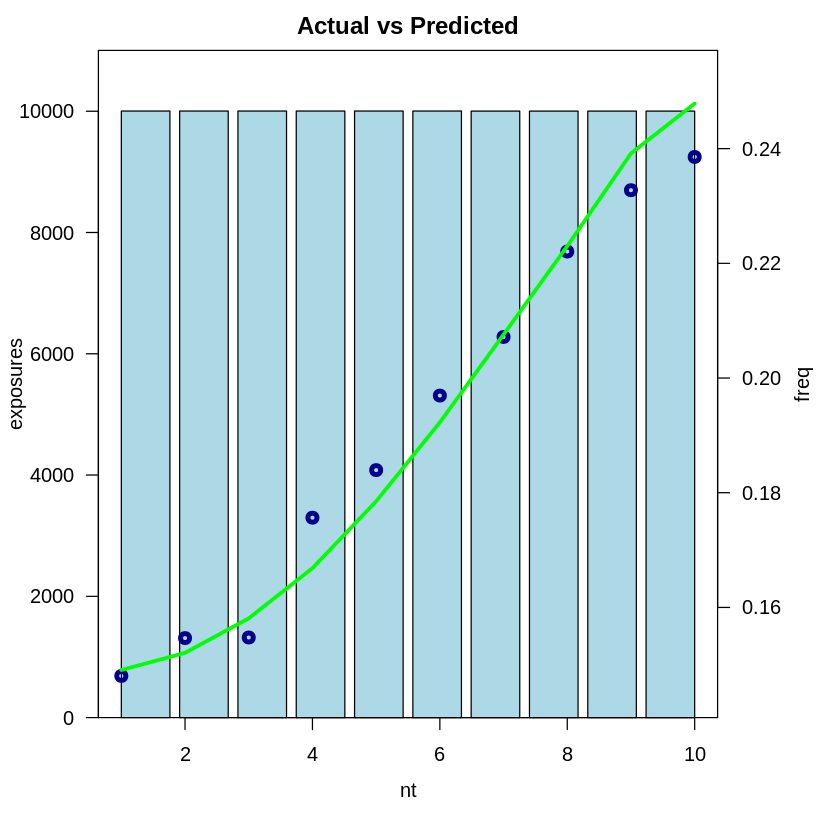

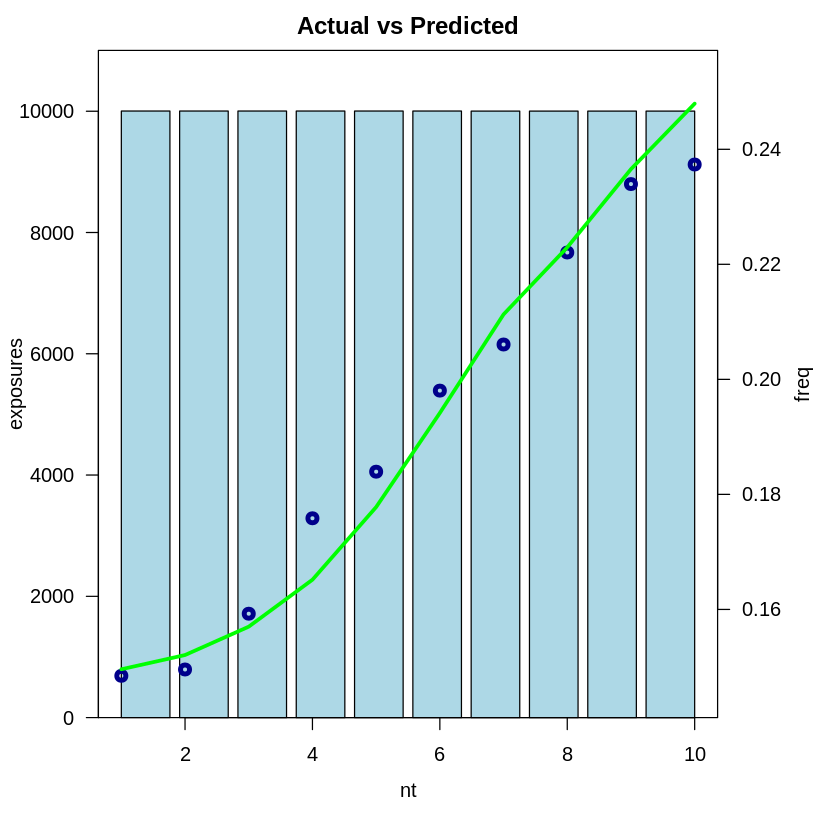

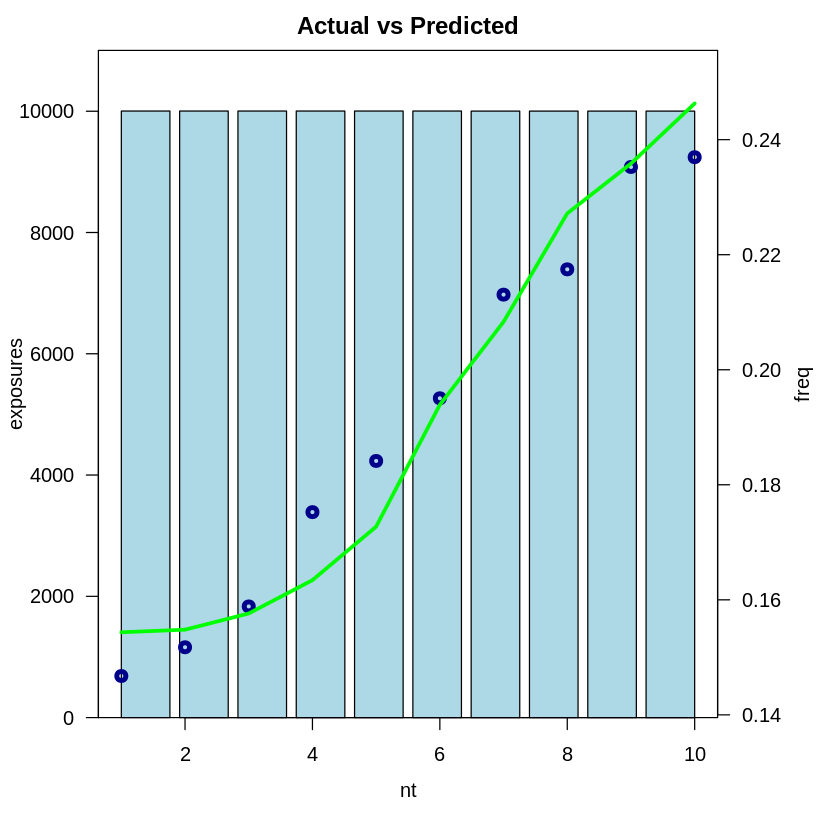

In [158]:
df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm2, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm2",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm3, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm3",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm4, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm4",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.glm9, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.glm9",weight="exposures",lt_text="exposures",rt_text="freq")

df.test <- df.test %>%
  mutate(nt = ntile(y.pred.gbm, 10))
avse.plot.classification(var="nt",data=df.test,actual="y.out",pred="y.pred.gbm",weight="exposures",lt_text="exposures",rt_text="freq")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



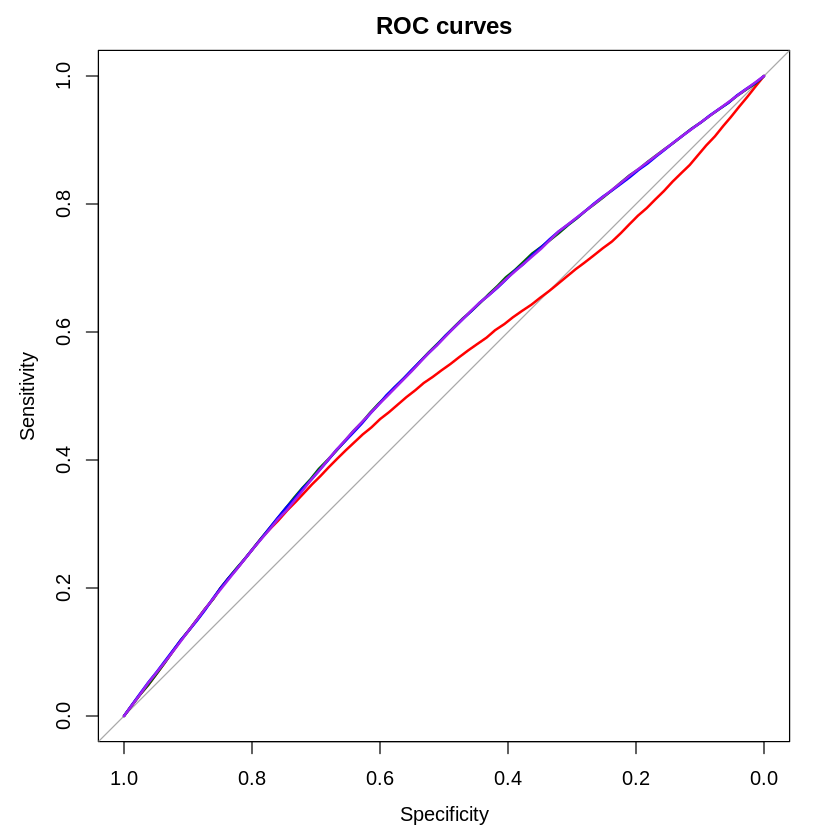

In [166]:
roc.score.glm <- roc(y.test, df.test$y.pred.glm)
plot(roc.score.glm, main ="ROC curves", col = "red")

roc.score.glm2 <- roc(y.test, df.test$y.pred.glm2)
plot(roc.score.glm2, col = "darkgreen", add = TRUE)

roc.score.glm4 <- roc(y.test, df.test$y.pred.glm4)
plot(roc.score.glm4, col = "blue", add = TRUE)

roc.score.gbm <- roc(y.test, df.test$y.pred.gbm)
plot(roc.score.gbm, col = "purple", add = TRUE)

# roc_rose <- plot(roc(hacide.test$cls, pred_rose[,2]), print.auc = TRUE, col = "blue")
# roc_rose <- plot(roc(hacide.test$cls, pred_both[,2]), print.auc = TRUE, 
#                  col = "green", print.auc.y = .4, add = TRUE)

Since the ROC plots for GLM2, GLM4 and GBM all sit on top of each other, I expect the AUC's (area under ROC curve) to be comparable. Gini's are computed to be 2xAUC - 1, and I expect Gini's to behave similarly.

In [167]:
Model.Name <- c("GLM", "GLM2", "GLM4", "GBM")
ROC <- c( auc(y.test, df.test$y.pred.glm),
          auc(y.test, df.test$y.pred.glm2),
          auc(y.test, df.test$y.pred.glm4),
          auc(y.test, df.test$y.pred.gbm))
Gini <- 2*ROC - 1
data.frame(Model.Name, ROC, Gini)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Model.Name,ROC,Gini
<chr>,<dbl>,<dbl>
GLM,0.5233374,0.04667484
GLM2,0.5595293,0.11905866
GLM4,0.5592600,0.11852004
GBM,0.5589179,0.11783580


# Improve on the GBM - Hyperparameters and Tuning

We've already seen our first hyperparameter - number of trees (n.trees). Let's run a big gbm with 1000 trees instead of the default 100

In [170]:
m.gbm.big <- gbm(y.train~x.Age, data=x.train, distribution="bernoulli", n.trees=1000)

In [172]:
df.train$y.pred.gbm.big <- predict(m.gbm.big, newdata=df.train, type="response")
df.test$y.pred.gbm.big <- predict(m.gbm.big, newdata=df.test, type="response")
df2$f.pred.gbm.big <- predict(m.gbm.big, newdata=df2, type="response")

Using 1000 trees...


Using 1000 trees...


Using 1000 trees...




In [132]:
pretty.gbm.tree(m.gbm, i.tree=1)

,SplitVar,SplitCodePred,LeftNode,RightNode,MissingNode,ErrorReduction,Weight,Prediction
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,0,42.5000000000,1,2,3,38.02014,49987,-0.0008433682
1,-1,0.0230792328,-1,-1,-1,0.00000,17749,0.0230792328
2,-1,-0.0140142300,-1,-1,-1,0.00000,32238,-0.0140142300
3,-1,-0.0008433682,-1,-1,-1,0.00000,49987,-0.0008433682


# Simulated Example of the Day

Now, we're going to take the gbm for a spin. Our simulated example above is nice for an introduction, but is too trivial for my taste. Let's put something together a bit closer to what we would typically run.

For explorations, we will create the following data:
*   Age
*   Gender (y-correlated with Age)
*   Marital Status (exposure correlated with Age)
*   Tenure (some correlation with age)
*   Prior Claims (simulate multiple periods to compute)
*   Years Claim Free (simulate multiple periods to compute)
*   Territory (simple - Urban High/Low and Rural High/Low)
*   Vehicle Type (Sedan, Minivan, Trucks - Minivan corr w/MS and Trucks corr w/Terr)
*   Three generic - strong/moderate/moderate
*   Six generic - 3 weak, 3 no effect


Let's start by generating the portfolio. We'll create enough records to separate into a robust train and test set.

In [ ]:
N <- 200000
# Set up probabilities for Age
tmp1 <- 16:90
tmp2 <- tmp1 - 53
tmp3 <- tmp2 / 37
tmp4 <- dnorm(tmp3, 0, 1)
tmp5 <- sum(tmp4)
p.Age <- tmp4 / tmp5
rm(tmp1, tmp2, tmp3, tmp4, tmp5)
# End p.Age setup
x.Age <- sample(16:90, N, replace=TRUE, prob=p.Age)
x.Gender.M <- sample(0:1, N, replace=TRUE)
# Set up probabilities for Marital Status
tmp1 <- x.Age
tmp2 <- tmp1 - 40
tmp3 <- tmp2 / 10
tmp4 <- tmp3 / (1 + abs(tmp3))
tmp5 <- tmp4 + 0.8
p.MaritalStatus.M <- tmp5 * 0.5
rm(tmp1, tmp2, tmp3, tmp4, tmp5)
#End p.MaritalStatus.M setup
x.MaritalStatus.M <- vector(mode="integer", length=N)
for (i in 1:N) {
  p <- p.MaritalStatus.M[i]
  x.MaritalStatus.M[i] <- sample(0:1, 1, prob=c(1-p, p))
}
rm(p)
# Set up probabilities for Tenure
tmp1 <- 0:20
tmp2 <- 1 * (0.9 ** tmp1)
tmp3 <- sum(tmp2)
p.Tenure <- tmp2 / tmp3
rm(tmp1, tmp2, tmp3)
# End p.Tenure setup
x.Tenure <- sample(0:20, N, replace=TRUE, prob=p.Tenure)
  x.Tenure <- pmin(x.Tenure, x.Age - 16)
x.Territory.U <- sample(0:1, N, replace=TRUE, prob=c(0.8, 0.2))
# Set up correlated draw for VehicleType
x.VehicleType <- vector(mode="character", length=N)
for (i in 1:N) {
  p.VehicleType <- c(0.60, 0.10, 0.10, 0.10)
  if (x.MaritalStatus.M[i] == 1) {p.VehicleType[c(2,4)] = c(1.8, 0.9)}
  if (x.Territory.U[i] == 0) {p.VehicleType[3:4] = p.VehicleType[3:4] + 0.45} 
  p.VehicleType <- p.VehicleType / sum(p.VehicleType)
  x.VehicleType[i] <- sample(c("Sedan", "Minivan", "Pickup", "Other"), 1, prob=p.VehicleType)
}
rm(p.VehicleType)
# End VehicleType draw
x.V1 <- sample(1:10, N, replace=TRUE)
x.V2 <- sample(1:10, N, replace=TRUE)
x.V3 <- x.V2 + sample(-5:5, N, replace=TRUE)+5
x.V4 <- sample(1:10, N, replace=TRUE)
x.V5 <- sample(1:10, N, replace=TRUE)
x.V6 <- x.V5 + sample(-5:5, N, replace=TRUE)+5
x.V7 <- sample(1:10, N, replace=TRUE)
x.V8 <- sample(1:10, N, replace=TRUE)
x.V9 <- x.V5 + sample(-5:5, N, replace=TRUE)+5

df.tmp1 <- data.frame(x.Age, x.Gender.M, x.MaritalStatus.M, x.Tenure,
                      x.Territory.U, x.VehicleType,
                      x.V1, x.V2, x.V3,
                      x.V4, x.V5, x.V6,
                      x.V7, x.V8, x.V9)

df <- df.tmp1 %>%
  mutate( x.VehicleType.Sedan = as.integer(x.VehicleType == "Sedan"),
          x.VehicleType.Minivan = as.integer(x.VehicleType == "Minivan"),
          x.VehicleType.Pickup = as.integer(x.VehicleType == "Pickup"),
          x.VehicleType.Other = as.integer(x.VehicleType == "Other")) %>%
  select(-"x.VehicleType")

In [ ]:
summary(df)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.0000   Median :1.0000    Median : 5.000  
 Mean   :53.04   Mean   :0.4997   Mean   :0.5473    Mean   : 6.007  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 5.000   Median : 5.000   Median :11.0  
 Mean   :0.1995   Mean   : 5.504   Mean   : 5.491   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4             x.V5             x.V6    

Now, let's set some ground truths. That is, probabilities associated with the various characteristics.

In [ ]:
y.base <- 0.08
y.Age <- (1+0.25*cos((x.Age-15)*pi/45))
y.Gender.M <- 1 + x.Gender.M * (.05 + (pmax(0, 25-x.Age)/9 * 1))
y.MaritalStatus.M <- 1 - 0.1 * x.MaritalStatus.M
y.Tenure <- 0.5+5/(10+x.Tenure)
y.Territory.U <- 1 + .3 * x.Territory.U
y.VehicleType.Sedan <- 1
y.VehicleType.Minivan <- 1 - 0.15 * df$x.VehicleType.Pickup
y.VehicleType.Pickup <- 1 + 0.10 * df$x.VehicleType.Pickup
y.VehicleType.Other <- 1 + 0.15 * df$x.VehicleType.Other
y.V1 <- 1+.04*x.V1
y.V2 <- 1+.02*x.V2
y.V3 <- 1+.01*x.V3
y.V4 <- 1+.005*x.V4
y.V5 <- 1+.005*x.V5
y.V6 <- 1+.0025*x.V6
y.V7 <- 1
y.V8 <- 1
y.V9 <- 1
y.truth <- y.base * y.Age * y.Gender.M * y.MaritalStatus.M * y.Tenure * y.Territory.U *
            y.VehicleType.Sedan * y.VehicleType.Minivan *
            y.VehicleType.Pickup * y.VehicleType.Other *
            y.V1 * y.V2 * y.V3 * y.V4 * y.V5 * y.V6 * y.V7 * y.V8 * y.V9

In [ ]:
colnames(df)
summary(y.truth)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03961 0.08443 0.10322 0.11348 0.12897 0.60410 

In [ ]:
y.out <- rbinom(N, 1, prob=y.truth)

In [ ]:
df$y.truth <- y.truth
df$y.out <- y.out

In [ ]:
summary(df)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.0000   Median :1.0000    Median : 5.000  
 Mean   :53.04   Mean   :0.4997   Mean   :0.5473    Mean   : 6.007  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 5.000   Median : 5.000   Median :11.0  
 Mean   :0.1995   Mean   : 5.504   Mean   : 5.491   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4             x.V5             x.V6    

In [ ]:
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.8,0.2))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [ ]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]

In [ ]:
m.gbm <- gbm(y.train ~ ., data = x.train, distribution = "bernoulli")
y.pred.train <- predict(m.gbm, newdata=x.train, type="response")
y.pred.test <- predict(m.gbm, newdata=x.test, type="response")

Using 100 trees...


Using 100 trees...




In [ ]:
df.train.out <- bind_cols(x.train, data.frame(truth.train, y.train, y.pred.train))
df.train.out$exposures <- 1

df.test.out <- bind_cols(x.test, data.frame(truth.test, y.test, y.pred.test))
df.test.out$exposures <- 1

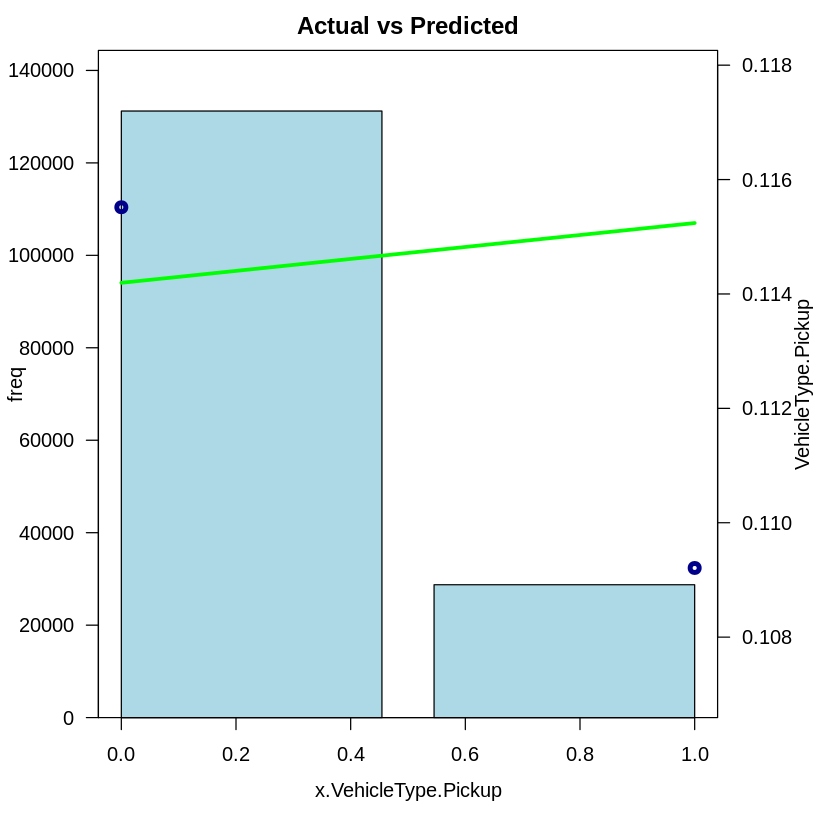

In [ ]:
avse.plot.classification(var="x.VehicleType.Pickup",rt_text="VehicleType.Pickup",data=df.train.out,actual="y.train",pred="y.pred.train",weight="exposures",lt_text="freq")

,var,rel.inf
,<chr>,<dbl>
x.Age,x.Age,59.9911830
x.Tenure,x.Tenure,11.2775730
x.Territory.U,x.Territory.U,7.7980195
x.V1,x.V1,6.8479378
x.V2,x.V2,6.1407653
x.VehicleType.Other,x.VehicleType.Other,3.3414660
x.MaritalStatus.M,x.MaritalStatus.M,2.3552747
x.Gender.M,x.Gender.M,0.9490110
x.V3,x.V3,0.9247080


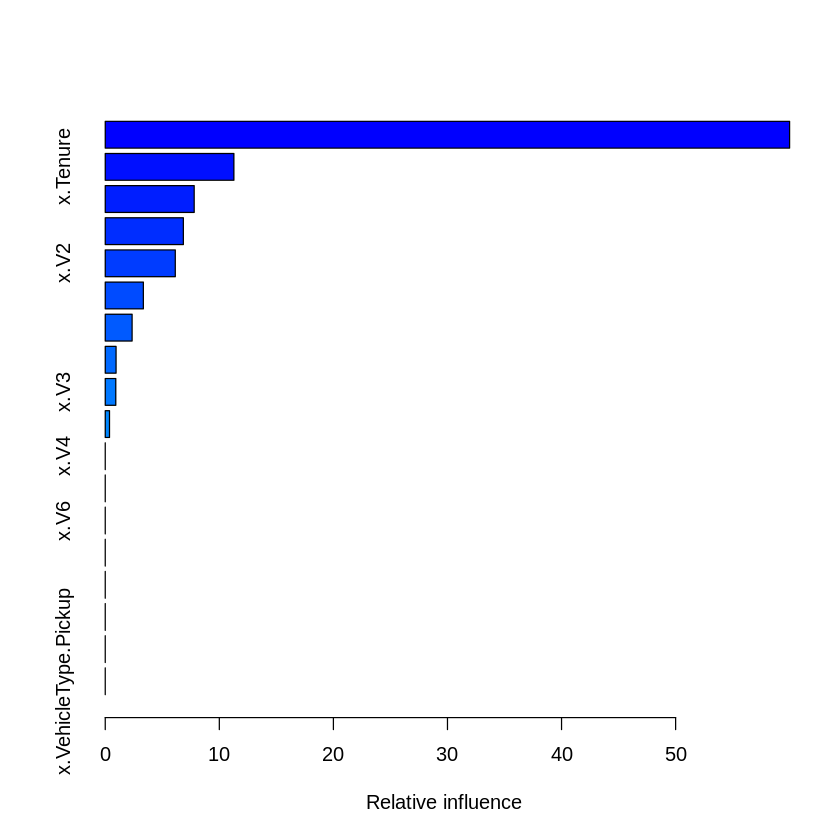

In [ ]:
summary.gbm(m.gbm)

In [ ]:
summary(df.train.out)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure    
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.00  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 8.00  
 Median :53.00   Median :0.0000   Median :1.0000    Median :13.00  
 Mean   :53.07   Mean   :0.4986   Mean   :0.5498    Mean   :12.38  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.:17.00  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.00  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 6.000   Median : 5.000   Median :10.0  
 Mean   :0.1987   Mean   : 5.506   Mean   : 5.499   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4            x.V5             x.V6           x

In [ ]:
summary(y.train)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1072  0.0000  1.0000 

In [ ]:
summary(df.train)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure    
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.00  
 1st Qu.:36.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 8.00  
 Median :53.00   Median :0.0000   Median :1.0000    Median :13.00  
 Mean   :52.88   Mean   :0.4993   Mean   :0.5472    Mean   :12.34  
 3rd Qu.:69.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.:17.00  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.00  
 x.Territory.U      x.V1             x.V2             x.V3      
 Min.   :0.0   Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.:0.0   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.00  
 Median :0.0   Median : 6.000   Median : 6.000   Median :10.00  
 Mean   :0.2   Mean   : 5.514   Mean   : 5.508   Mean   :10.51  
 3rd Qu.:0.0   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.00  
 Max.   :1.0   Max.   :10.000   Max.   :10.000   Max.   :20.00  
      x.V4             x.V5             x.V6           x.V7       
 M

# Load CSV datafile - Data split as train and test (80/20 split) and stored in git

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [ ]:
# train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
# test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
# train_data <- read.csv(file =train_file, header = TRUE )
# test_data <- read.csv(file =test_file, header = TRUE )
# x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
# y_train <- train_data$claim_count_pd
# x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
# y_test <- test_data$claim_count_pd

# Fit GLM model and Predict output for test data

In [ ]:
# Fit a GLM
# fit <- step(glm(y_train ~ ., data = x_train, family = "gaussian"), direction = "both", trace = FALSE)
# pred_y_test <- predict(fit, newdata = x_test, type = "response")
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_GLM <- data.frame(pred_y_test_bin, y_test)
#write.csv(dataout_GLM, "GLM_stepwise_allfeatures.csv", row.names=FALSE)


#Fit GBM model and Predict output for test with standard hyperparameters

In [ ]:
# fit <- gbm(y_train ~ ., data = x_train, distribution = "gaussian", n.trees = 100, interaction.depth = 5)
# pred_y_test = predict.gbm(fit, x_test)
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_GBM <- data.frame(pred_y_test_bin, y_test)


Using 100 trees...




#XGboost with standard hyperparameters ( no tuning) 

In [ ]:
# fit <- xgboost(data = as.matrix(x_train), label = y_train, nrounds = 100, objective = "binary:logistic", eta = 0.3, max_depth = 6,silent = 1)
# pred_y_test <- predict(fit, as.matrix(x_test)) # Predict the classes for the test data
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test)

#Calcualte the metric for each model

In [ ]:
# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [ ]:
knitr::kable(metrics_df,digits = 2)



|var_name | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|  TP| FP|    TN|   FN| Samples|
|:--------|--------:|---------:|-----------:|--------:|---------:|----:|---:|--:|-----:|----:|-------:|
|XGBoost  |     0.91|      0.98|        0.07|     0.13| 0.5360971| 0.07| 580|  9| 71971| 7440|   80000|
|GBM      |     0.90|      1.00|        0.00|     0.00| 0.5001247| 0.00|   2|  0| 71980| 8018|   80000|
|GLM      |     0.90|      0.50|        0.00|     0.00| 0.5001108| 0.00|   2|  2| 71978| 8018|   80000|

#Plot the various metrics as plots

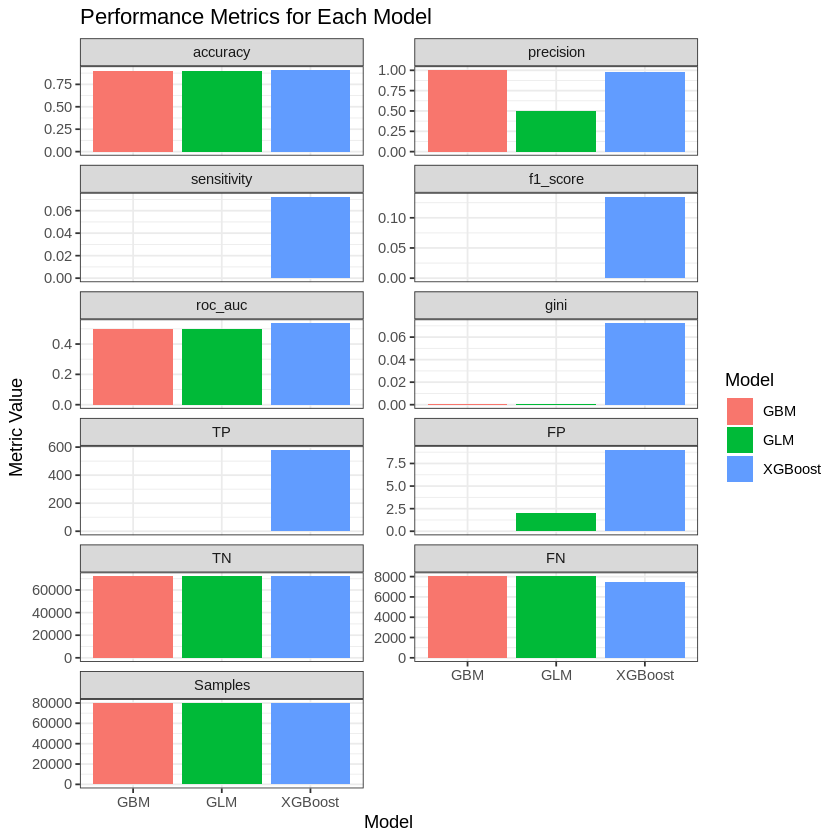

In [ ]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

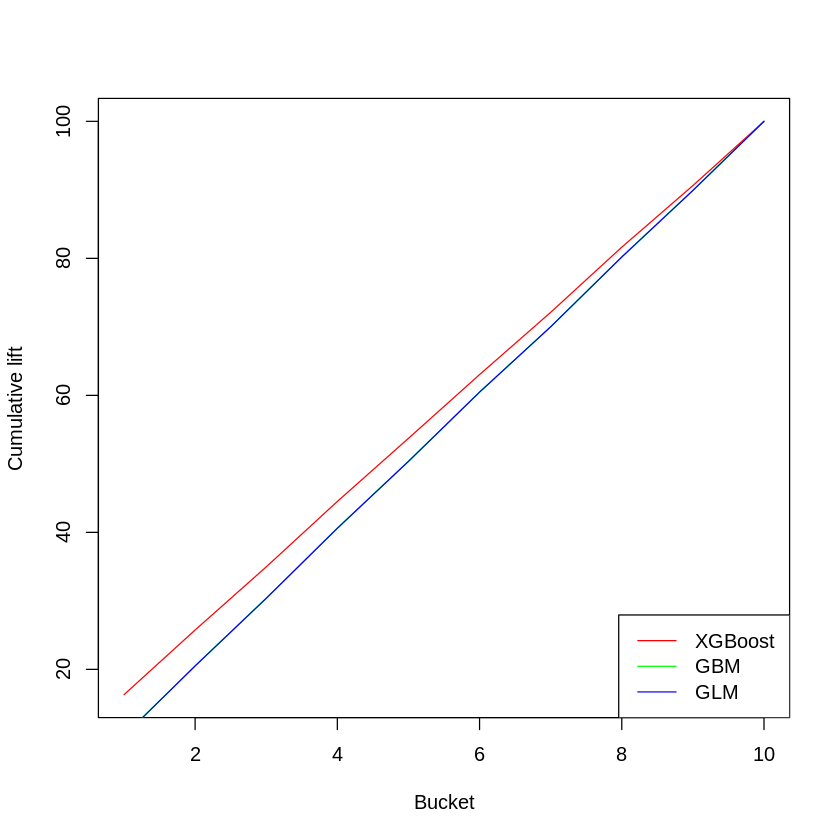

In [ ]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GBM$y_test, dataout_GBM$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GBM", "GLM"), col=c("red", "green", "blue"), lty=1)

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)

In [ ]:
#library(flextable)
# Convert the data frame to a flextable object
ft_metrics <- flextable(metrics_df)
ft_metrics <- set_formatter(ft_metrics, type = "numeric", digits = 2) # Set the number of decimal places for numeric columns

ft_metrics <- set_header_labels(ft_metrics, var_name = "Model", Samples = "Total Samples")
ft_metrics <- autofit(ft_metrics)
ft_metrics <- add_header_row(ft_metrics, values = "Performance Metrics", merge = 11)
print(ft_metrics)